# Creating synthetic datasets

## Imports

In [8]:
# !pip install wikipedia-api

In [9]:
import re
import json
import random
from collections.abc import Callable
from typing import Any
from collections import deque
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps
import cv2

from sklearn.feature_extraction.text import CountVectorizer
import wikipediaapi

from doctr import transforms as T
from torchvision.transforms import v2
import albumentations as A

from castom_utils import (load_config, 
                          write_json,
                          read_json,
                          Ansi, 
                          valid_fonts, 
                          get_fonts_from_folder, 
                          get_system_fonts,
                          translate_text,
                          ColorShiftTorch,
                          ColorShiftAlb,
                          )

In [10]:
def draw_images(path, num=16):
    annotations = read_json(path / 'labels.json')
    img_names = np.random.choice(list(annotations.keys()), num)
    
    fig, axes = plt.subplots(num // 2, 2, figsize=(6, num / 2))
    fig.suptitle('Примеры сгенерированных изображений', fontweight='bold')
    for ax, img_name in zip(axes.flat, img_names):
        img = Image.open(path.joinpath('images', img_name)).convert('RGB')
        # img = ImageOps.invert(img)
        ax.set_title(annotations[img_name])
        ax.imshow(img)
        ax.axis('off')
    plt.show()  

In [11]:
def draw_boxes(path, image_size=15):
    annotations = read_json(path / 'labels.json')   
    img_name = np.random.choice(list(annotations.keys()))

    boxes = annotations[img_name]['boxes']
    img = Image.open(path.joinpath('images', img_name)).convert('RGB')
    draw = ImageDraw.Draw(img)
    
    width, height = img.size
    boxes = np.array(boxes) * np.array([width, height, width, height])
    boxes = boxes.astype(np.int32).tolist()
    for bbox in boxes:
        draw.rectangle(bbox, outline='green', width=1)

    plt.figure(figsize=(image_size, image_size))
    plt.title(img_name)
    plt.imshow(img)
    plt.show()

    print(annotations[img_name]['text'])

In [12]:
CFG = load_config()

Config is loaded!
List of all chars used (114):
0123456789!"'#%&()*+,-./:;<=>?@[\]^_{|}~№°$£€¥¢₽АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


## Text parsing

Для обучения модели распознавания текста текста с изображений нам понадобится тренировочный и валидационный датасеты.  
Так как задача состоит в распознавании печатного текста, то тренировочные данные можно синтетически сгенерировать. В качестве источников текстовых данных используем API Википедии, откуда спарсим случайные русскоязычные статьи.

In [13]:
def _clean_text(text: list[str]):
    """
    Очищает текст, оставляя только слова, состоящие из символов из списка character.
    Удаляет слова, содержащие хотя бы один символ не из списка.
    """
    valid_text = []
    valid_char_regex = re.compile(f"[{re.escape(CFG.vocab_train)}]+")
    
    for txt in text:
        txt = txt.strip()
        # Заменяем последовательности пробелов, табуляций, переносов строк на один пробел
        txt = re.sub(r'\s+', ' ', txt)
        # Удаляем диакритические знаки
        txt = re.sub(r'[\u0300-\u036f]+', '', txt)
        # Удаляет знаки препинания в начале строки, при наличии
        txt = re.sub(r"^[^\w\d]+", "", txt)
        # Разбиваем текст на слова
        words = txt.split(' ') 
        # Оставляем только слова, которые полностью соответствуют списку символов
        valid_words = [word for word in words if valid_char_regex.fullmatch(word)]
        # Записываем очищенную строку
        txt = ' '.join(valid_words)
        # Оставляем только длинные абзацы
        if len(txt) > 20:
            valid_text.append(txt)

    return valid_text

In [14]:
def _extract_section_text(section, stop_sections):
    """
    Рекурсивно извлекает текст секции и её подсекций, игнорируя нежелательные.
    """
    section_text = []

    # Проверяем, не относится ли секция к нежелательным
    if section.title.lower() not in stop_sections:
        section_text.extend(section.text.split('\n'))

        # Рекурсивно обрабатываем подсекции
        for subsection in section.sections:
            section_text.extend(_extract_section_text(subsection, stop_sections))

    return section_text


def _get_wikipedia_text(page):
    text = []
    text.extend(page.summary.split('\n'))
    stop_sections = set(('cм. также', 'примечания', 'литература', 'ссылки'))
    
    for section in page.sections:
        text.extend(_extract_section_text(section, stop_sections))

    return _clean_text(text)

In [15]:
def parsing_wikipedia_articles(
    root_topic: list, 
    language='ru', 
    max_articles=5, 
    search_depth=3,
    num_workers=None
):
    """
    Парсинг случайных статей из Википедии по заданной тематике.
    """
    wiki = wikipediaapi.Wikipedia('Wikipedia-API', language, timeout=20)
    articles = []  # Список текстов статей
    visited_topics = set()  # Для отслеживания уже посещённых тем
    queue = deque(root_topic)  # Очередь для обхода связанных тем
    search_depth += len(root_topic)
    cnt_add_queue = 0

    # Распараллеливание процессов
    progress_bar = tqdm(total=max_articles, desc='Making list of articles')
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        while queue and len(visited_topics) < max_articles:
            # Берем название статьи из начала очереди
            current_topic = queue.popleft()

            # Пропускаем посещенные статьи
            if current_topic in visited_topics:
                continue

            # Загрузка текущей страницы
            page = wiki.page(current_topic)
            if page.exists():
                # Добавляем страницу в очередь на обработку во многопотоке
                futures.append(executor.submit(_get_wikipedia_text, page))
                
                # Добавляем статью в список посещенных
                visited_topics.add(current_topic)

                # Добавление связанных статей в очередь
                if cnt_add_queue <= search_depth:
                    links = list(page.links.keys())
                    queue.extend(links)
                    cnt_add_queue += 1
                    # Если мы прошлись по всем статьям из списка root_topic,
                    # то случайным образом перемешиваем очередь статей
                    if cnt_add_queue >= len(root_topic):
                        random.shuffle(queue)

                progress_bar.update(1)

        # Обработка результатов
        for future in tqdm(futures, desc='Articles parsing'):
            text = future.result()
            articles.extend(text)

    # INFOMATION
    visited_topics = list(visited_topics)
    sample_topics = np.random.choice(
        visited_topics, 
        size=min(10, len(visited_topics)), 
        replace=False
    ).tolist()

    sample_topics = [f' - {word}' for word in sample_topics]

    print(f'{Ansi.bold}Несколько случайных названий загруженных статей:{Ansi.end}')
    print('\n'.join(sample_topics))
    
    return articles

Важный момент, по умолчанию векторайзеры из sklearn отбрасывают знаки пунктуации, которые должна уметь распознавать модель. Поэтому меняем регулярное выражение в **token_pattern**, что бы сохранить пунктуацию в тексте.

In [16]:
def text_split(texts: list, max_length=20, ngram_range=(2, 5), token_pattern=r"\S+"):
    """
    Разбивает текст на фразы с использованием CountVectorizer для генерации n-грамм.
    """
    vectorizer = CountVectorizer(
        ngram_range=ngram_range, 
        analyzer='word', 
        lowercase=False,
        token_pattern=token_pattern,
        stop_words=None
        )
    _ = vectorizer.fit_transform(texts)
    ngrams = vectorizer.get_feature_names_out()

    # Отбираем n-граммы, которые не превышают max_length
    filtered_phrases = [
        ngram for ngram in ngrams if len(ngram) <= max_length
    ]

    # INFO
    random_phrases = random.choices(filtered_phrases, k=10)
    random_phrases = [f' - {word}' for word in random_phrases]

    print(f'Сформировано различных фраз: {Ansi.bold}{len(filtered_phrases)}{Ansi.end}\n')
    print(f'{Ansi.bold}Несколько случайных фраз:{Ansi.end}')
    print('\n'.join(random_phrases))
    
    return filtered_phrases

In [17]:
# Парсинг статей из Википедии
# articles = parsing_wikipedia_articles(
#     ['Наука', 'Образование', 'Математика', 'Физика'],
#     max_articles=1000,
#     search_depth=20,
#     num_workers=4,
# )

In [18]:
# Write
# write_json(CFG.dataset_synthetic / 'articles.json', articles)

# Read
articles = read_json(CFG.dataset_synthetic / 'articles.json')

Нарезаем текст на отдельные слова для обучения recognition model

In [19]:
# Предобработка текста
phrases = text_split(
    articles,
    max_length=30, 
    ngram_range=(1, 1)
)

Сформировано различных фраз: 256828

Несколько случайных фраз:
 - вычислялся
 - сладчайший.
 - историей»,
 - Алгебраическое
 - Общей
 - селекторы
 - новейшей
 - неприятельского
 - «министр
 - реминисценций,


## Fonts

Получим список системных шрифтов, поддерживающих все символы, которые нам необходимо уметь распознавать.  
Так же можно загрузить шрифты, к примеру с [Google fonts](https://fonts.google.com).  
При генерации каждого отдельного изображения будем случайно выбирать один из доступных шрифтов.  
Различные случайные аугментации (шум, искажения, изменение яркости и т.д) будут применяться непосредственно при обучении моделей.

In [20]:
# Получим список заранее скачанных шрифтов из папки. 
# Так же можно использовать шрифты, установленные в системе.
total_fonts = get_fonts_from_folder(CFG.fonts) #+ get_system_fonts()

# Отберем только те шрифты, которые поддерживают все необходимые нам символы
good_fonts = valid_fonts(total_fonts, CFG.vocab_train_unicode) #CFG.vocab_train_unicode
print(f"Найдено подходящих шрифтов: {Ansi.bold}{len(good_fonts)}{Ansi.end}")

Найдено подходящих шрифтов: 265


In [21]:
# txt = 'съешь еще этих мягких французских булок'

# for font_path in good_fonts[:30]:
#     font = ImageFont.truetype(font_path, size=30)
#     bbox = font.getbbox(txt)
#     text_width = bbox[2] - bbox[0]
#     text_height = bbox[3] - bbox[1]
    
#     img = Image.new('L', (text_width, text_height), color=255)
#     draw = ImageDraw.Draw(img)
#     draw.text((0, -bbox[1]), txt, font=font)

#     print(font_path)
#     plt.imshow(img, cmap='gray')
#     plt.show()

## Generating images for recognition

Текстовая информация получена. Далее на ее основе сгенерируем изображения и составим датасет, где каждой картинке будет соответствовать определенный текст

In [22]:
transforms_alb = A.Compose([
    A.ShiftScaleRotate(shift_limit=.05, scale_limit=0.0, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, fill=255, p=.5),
    A.GaussianBlur(blur_limit=(1, 3), p=.3),
    A.RandomSunFlare(flare_roi=(0, 0, 1, 1), src_radius=60, p=.2),
    # A.GaussNoise(var_limit=(100, 600), p=.1),
    A.ElasticTransform(alpha=3, sigma=50, p=.1),
    # A.ColorJitter(brightness=.4, contrast=.4, saturation=.4, hue=.4, p=.4),
])


transforms = v2.Compose([
    ColorShiftTorch(min_val=.6, p=.9),
    # T.RandomApply(v2.ElasticTransform(alpha=5, sigma=5, fill=255), p=.35),
    T.RandomApply(T.GaussianNoise(mean=0, std=0.15), p=.2),
    v2.RandomPhotometricDistort(brightness=(.7, 1.3), contrast=(.6, 1.4), hue=(-.3, .3), p=.25),
    T.RandomApply(v2.RandomRotation(degrees=2, expand=True), p=.7),
    v2.RandomPerspective(distortion_scale=.2, p=1),
    v2.RandomGrayscale(p=.25),
    T.RandomApply(T.RandomShadow(), p=.2),
])

In [23]:
def _generate_string(min_chars: int, max_chars: int) -> str:
    num_chars = random.randint(min_chars, max_chars)
    return "".join(random.choice(CFG.vocab_train) for _ in range(num_chars))

In [24]:
def _generate_recognition_image(i, text, font_path, output_dir, need_transforms=False):
    font_size = 32
    background_color = (255, 255, 255)
    text_color = (0, 0, 0)

    font = ImageFont.truetype(font_path, font_size)
    left, top, right, bottom = font.getbbox(text)
    w, h = right - left, bottom - top
    
    img = Image.new('RGB', (w, h), color=background_color)
    draw = ImageDraw.Draw(img)
    draw.text((0, -top), text, font=font, fill=text_color)

    mw = max(3, (int(round(.07 * w))))
    mh = max(3, (int(round(.15 * h))))
    margin = (mw, mh, mw, mh)
    img = ImageOps.expand(img, margin, fill=background_color)

    if need_transforms:
        img = np.array(img)
        img = transforms_alb(image=img)['image']
        # img = Image.fromarray(img)
        img = v2.functional.to_image(img)
        img = transforms(img)
        img = v2.functional.to_pil_image(img)

    # Сохранение изображения
    img_name = f"text_{i:07d}.png"
    img_path = output_dir.joinpath('images', img_name)
    img.save(img_path)

    # Заменяем некоторые редковстречающиеся символы на универсальные.
    # Например, что бы модель разные типы ковычек '«»„' интерпретировала как '"'
    text = translate_text(text, CFG.vocab_replace)

    return img_name, text

In [25]:
def generate_recognition_dataset(
    output_dir, 
    fonts, 
    num_images, 
    text_samples: list[str] | None = None,
    p_randgen: float = 0,
    p_upper: float = .25,
    need_transforms=False,
    num_workers=None
):
    """
    Генерирует синтетический датасет из изображений.
    """
    if not (0 <= p_randgen <= 1):
        raise ValueError('p_randgen must be between 0 and 1.')

    valid_char_regex = re.compile(f"[{re.escape(CFG.vocab)}]+")
        
    output_dir.joinpath('images').mkdir(parents=True, exist_ok=True)
    annotations = {}

    # Распараллеливание процессов
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for i in range(num_images):
            # Случайный текст и шрифт
            font_path = random.choice(fonts)

            if random.random() < p_randgen:
                text = _generate_string(1, 17)
            else:
                text = random.choice(text_samples)
                # С некоторой вероятностью пишем текст капсом.
                # В том случае, если после приведения к верхнему регистру 
                # в тексте не появится не включенных в разрешенный список символов.
                if random.random() < p_upper and valid_char_regex.fullmatch(text.upper()):
                    text = text.upper()
                
            futures.append(executor.submit(_generate_recognition_image, i, text, font_path, output_dir, need_transforms))
            
        # Обработка результатов
        for future in tqdm(futures, desc=f'Images generation "{output_dir.name}"'):
            img_name, text = future.result()
            annotations[img_name] = text

    # Сохранение аннотаций в json
    write_json(output_dir / 'labels.json', annotations)

Определяем размеры датасетов и cгенерируем изображения.

In [ ]:
train1_size = 200000
train2_size = 1000000
val_size = 30000

# generate_recognition_dataset(CFG.dataset_synthetic / 'recognition' / 'train1', good_fonts, train1_size, p_randgen=1)
# generate_recognition_dataset(CFG.dataset_synthetic / 'recognition' / 'train2', good_fonts, train2_size, phrases, p_randgen=0)
# generate_recognition_dataset(CFG.dataset_synthetic / 'recognition' / 'val2', good_fonts, val_size, phrases, p_randgen=.1, need_transforms=True, num_workers=1)

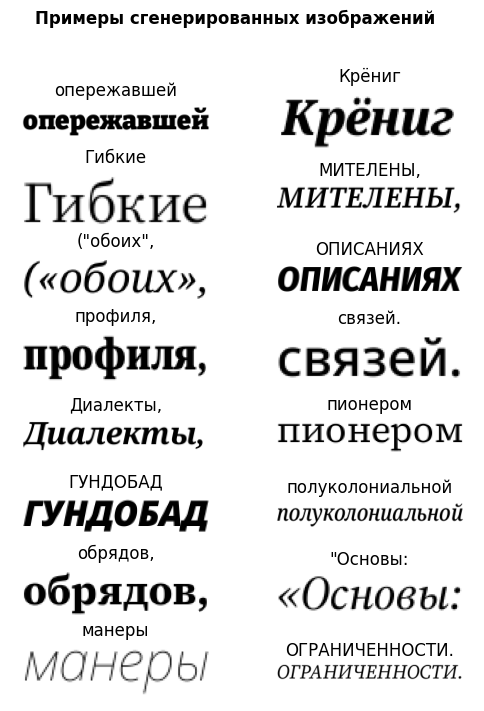

In [28]:
draw_images(CFG.dataset_synthetic / 'recognition' / 'train2')

## Generating images for detection

Похожим образом сформируем датасет для detection model. Но теперь будем формировать целые страницы с разметкой bounding boxes для отдельных слов.  
Для генерирования текста будем брать несколько случайных абзацев из загруженных с Википедии статей, перемешивать их между собой, а затем составлять их них целый текст.

In [37]:
bbox_params=A.BboxParams(format='albumentations', label_fields=['labels'])

# Image + target augmentations
transforms_alb = A.Compose([
    # A.LongestMaxSize(max_size=INPUT_SIZE),
    A.ColorJitter(brightness=.4, contrast=.4, saturation=.4, hue=.4, p=.25),
    # A.RandomSunFlare(flare_roi=(0, 0, 1, 1), src_radius=150,  p=1),
    A.InvertImg(p=.1),
    ColorShiftAlb(min_val=.6, p=.9),
    A.ToGray(p=.2),
    A.Affine(rotate=(-1, 1), fit_output=True, border_mode=cv2.BORDER_CONSTANT, p=.6),
    # A.ShiftScaleRotate(shift_limit=.15, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=.4),
    A.Perspective(scale=(.01, .01), fit_output=True, p=.6),
    A.GaussianBlur(blur_limit=(1, 3), p=.3),
    A.GaussNoise(std_range=(.1, .1), p=.1),
    A.ElasticTransform(alpha=5, sigma=50, p=.2),
    ], bbox_params=bbox_params)

In [38]:
def _generate_recognition_image(i, output_dir, text: list, font_path, page_size, need_transforms=False):
    font_size = random.randint(17, 25)
    font = ImageFont.truetype(font_path, font_size)
    font_height = sum(font.getmetrics()) # Высота текста
    line_spacing = random.randint(0, 7)  # Межстрочный интервал
    paragraph_margin = random.randint(0, 50) # Отступ для начала абзаца

    background_color = (255, 255, 255)
    text_color = (0, 0, 0)
    img = Image.new('RGB', page_size, color=background_color)
    draw = ImageDraw.Draw(img)

    # Отступ координат bounding boxes от края букв
    margin_box = 1
    # Добавляем случайные отступы с каждой из сторон страницы
    margin = tuple(random.randint(5, 40) for _ in range(4)) # left, top, right, bottom
    # Начальная позиция для текста по вертикали
    y_offset = margin[1]

    boxes, text_img = [], []

    for sentence in text:
        # Начальная позиция по горизонтали
        x_offset = margin[0] + paragraph_margin

        # Разбиваем текст на слова
        words = sentence.split(' ')
        for word in words:
            bbox_word = font.getbbox(word)

            if x_offset + bbox_word[2] > page_size[0] - margin[2]:  # Если слово не помещается в строке
                y_offset += font_height + line_spacing
                x_offset = margin[0]
                text_img.append('\n')

            if y_offset + font_height > page_size[1] - margin[3]:  # Если достигли конца страницы
                text_img.append('\n')
                break

            # Отрисовываем слово
            draw.text((x_offset, y_offset), word, fill=text_color, font=font)
            #  Сохраняем его bounding box
            # bbox = [
            #     [x_offset + bbox_word[0] - margin_box, y_offset + bbox_word[1] - margin_box],
            #     [x_offset + bbox_word[2] + margin_box, y_offset + bbox_word[1] - margin_box],
            #     [x_offset + bbox_word[2] + margin_box, y_offset + bbox_word[3] + margin_box],
            #     [x_offset + bbox_word[0] - margin_box, y_offset + bbox_word[3] + margin_box],
            # ]
            bbox = [
                (x_offset + bbox_word[0] - margin_box) / page_size[0], 
                (y_offset + bbox_word[1] - margin_box) / page_size[1],
                (x_offset + bbox_word[2] + margin_box) / page_size[0], 
                (y_offset + bbox_word[3] + margin_box) / page_size[1],
            ]
            boxes.append(bbox)
            text_img.append(word)

            # Обновляем отступ для следующего слова, учитывая длину пробела
            x_offset += bbox_word[2] + int(font.getlength(' '))

        # Переход на следующую строку
        y_offset += font_height + line_spacing
        text_img.append('\n')
        if y_offset > page_size[1] - margin[3]:
            break

    if need_transforms:
        img = np.array(img)
        transformed = transforms_alb(image=img, bboxes=boxes, labels=[0] * len(boxes))
        img, boxes = transformed['image'], transformed['bboxes']
        img = Image.fromarray(img)

    img_name = f"page_{i:05d}.png"
    img_path = output_dir.joinpath('images', img_name)
    img.save(img_path)

    # words_img = [word for word in text_img if word != '\n']
    text_img = ' '.join(text_img)
    text_img = re.sub(r'\s*\n\s*', '\n', text_img)
    text_img = translate_text(text_img, CFG.vocab_replace)
    
    annotation = {
        'boxes': boxes,
        # 'words': words_img,
        'text': text_img,
    }

    return img_name, annotation

In [39]:
def generate_detection_dataset(
    output_dir, 
    fonts, 
    articles, 
    num_pages, 
    page_size=(800, 1200), 
    need_transforms=False,
    num_workers=None
):
    """
    Генерирует синтетический датасет страниц текста с bounding box для каждого слова.
    """
    output_dir.joinpath('images').mkdir(parents=True, exist_ok=True)
    annotations = {}

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for i in range(num_pages):
            # Случайный выбор шрифта
            font_path = random.choice(fonts)
            # Случайным образом выбираем несколько абзацев
            text = random.sample(articles, k=random.randint(8, 20))
            futures.append(executor.submit(_generate_recognition_image, i, output_dir, text, font_path, page_size, need_transforms))

        # Обработка результатов
        for future in tqdm(futures, desc=f'Images generation "{output_dir.name}"'):
            img_name, annot = future.result()
            annotations[img_name] = annot

    # Сохранение аннотаций в json
    write_json(output_dir / 'labels.json', annotations)

In [40]:
train_size = 2000
val_size = 200
test_size = 50

# generate_detection_dataset(CFG.dataset_synthetic / 'detection' / 'train', good_fonts, articles, num_pages=train_size)
# generate_detection_dataset(CFG.dataset_synthetic / 'detection' / 'val', good_fonts, articles, num_pages=val_size, need_transforms=True, num_workers=1)
generate_detection_dataset(CFG.dataset_test / 'synthetic', good_fonts, articles, num_pages=test_size, need_transforms=True, num_workers=1)

Images generation "synthetic":   0%|          | 0/50 [00:00<?, ?it/s]

Взглянем на случайный пример сгенерированного изображения и получившейся разметки для обучения модели.  
Различные случайные аугментации для повышения вариативности данных будут применяться при обучении.

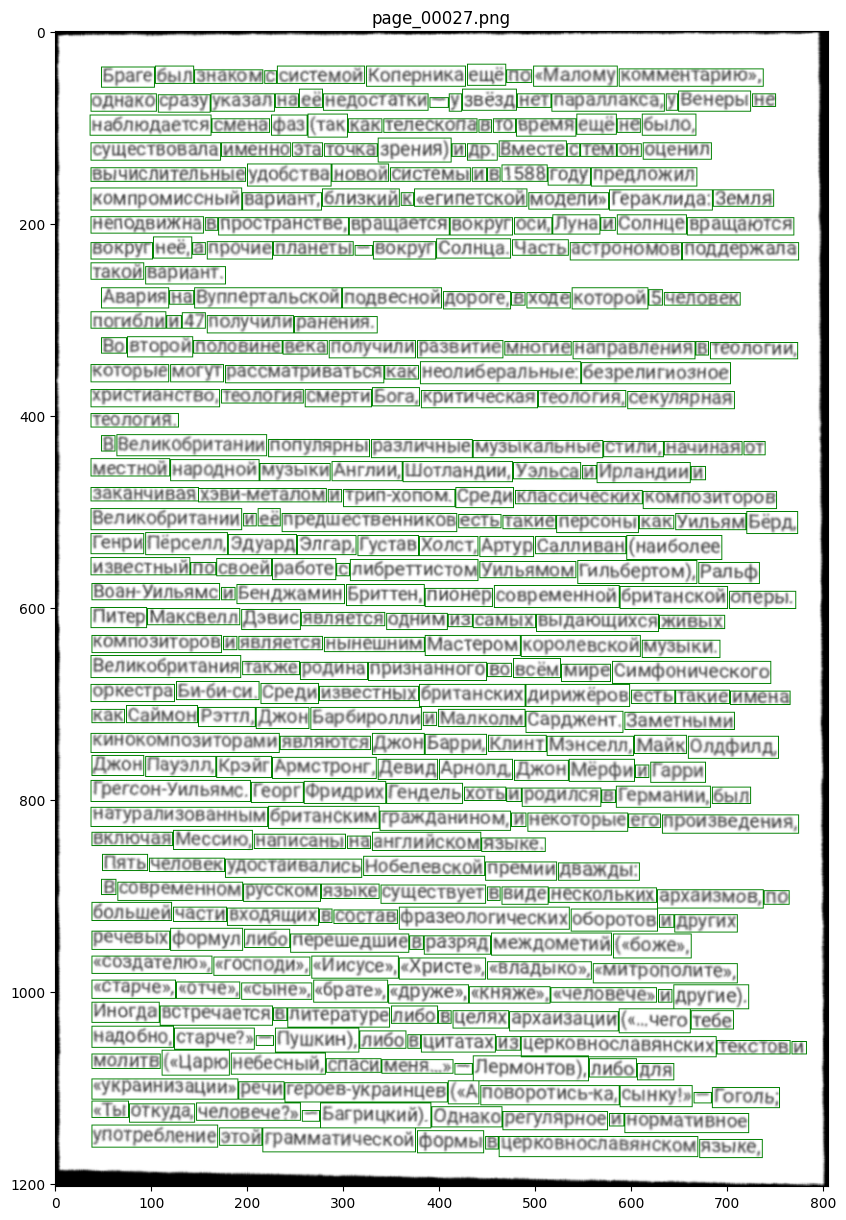

Браге был знаком с системой Коперника ещё по "Малому комментарию",
однако сразу указал на её недостатки - у звёзд нет параллакса, у Венеры не
наблюдается смена фаз (так как телескопа в то время ещё не было,
существовала именно эта точка зрения) и др. Вместе с тем он оценил
вычислительные удобства новой системы и в 1588 году предложил
компромиссный вариант, близкий к "египетской модели" Гераклида: Земля
неподвижна в пространстве, вращается вокруг оси, Луна и Солнце вращаются
вокруг неё, а прочие планеты - вокруг Солнца. Часть астрономов поддержала
такой вариант.
Авария на Вуппертальской подвесной дороге, в ходе которой 5 человек
погибли и 47 получили ранения.
Во второй половине века получили развитие многие направления в теологии,
которые могут рассматриваться как неолиберальные: безрелигиозное
христианство, теология смерти Бога, критическая теология, секулярная
теология.
В Великобритании популярны различные музыкальные стили, начиная от
местной народной музыки Англии, Шотландии, Уэльса

In [41]:
# draw_boxes(CFG.dataset_synthetic / 'detection' / 'val', image_size=15)
draw_boxes(CFG.dataset_test / 'synthetic', image_size=15)